<a href="https://colab.research.google.com/github/BagusAth/Integrating-AI/blob/main/CNN_%26_Transfer_Lerning_H8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook ini dibuat oleh: **Sardi Irfansyah**

# Introduction

Pada sesi ini kalian akan hands-on bersama dengan instruktur kalian untuk melakukan klasifikasi gambar dengan CNN & transfer learning. Dataset yang digunakan dari link berikut: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia   .

Misalkan untuk transfer learning kita akan gunakan VGG16 dan Xception.

Agar proses training lebih cepat gunakanlah GPU, caranya:
- Klik menu **Runtime** pada google colab
- Pilih **Change Runtime Type**
- Lalu pada Hardware Accelerator , pilih GPU.


# Import Libraries

In [1]:
!pip -q install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.16.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.1 which is incompatible.


In [5]:
!pip install -q tensorflow-addons==0.20.0

In [58]:
import tensorflow as tf
import os
import glob
import numpy as np
import random
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image

In [27]:
tf.__version__

'2.16.1'

# Data Loading

In [59]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
!unzip -q /content/chest-xray-pneumonia.zip

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [61]:
import os # Import the os module
os.listdir('/content/chest_xray')

['chest_xray', 'train', 'val', '__MACOSX', 'test']

In [62]:
print('jumlah normal di data train:', len(os.listdir('/content/chest_xray/train/NORMAL')))
print('jumlah pneumonia di data train:', len(os.listdir('/content/chest_xray/train/PNEUMONIA')))

jumlah normal di data train: 1341
jumlah pneumonia di data train: 3875


In [63]:
list_label= ['NORMAL','PNEUMONIA']
for label in list_label:
  print(f'jumlah {label} di data train:',
        len(os.listdir(f'/content/chest_xray/train/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875


In [64]:
list_label= ['NORMAL','PNEUMONIA']
list_folder= ['train','test','val']
for folder in list_folder:
  for label in list_label:
    print(f'jumlah {label} di data {folder}:',
          len(os.listdir(f'/content/chest_xray/{folder}/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875
jumlah NORMAL di data test: 234
jumlah PNEUMONIA di data test: 390
jumlah NORMAL di data val: 8
jumlah PNEUMONIA di data val: 8


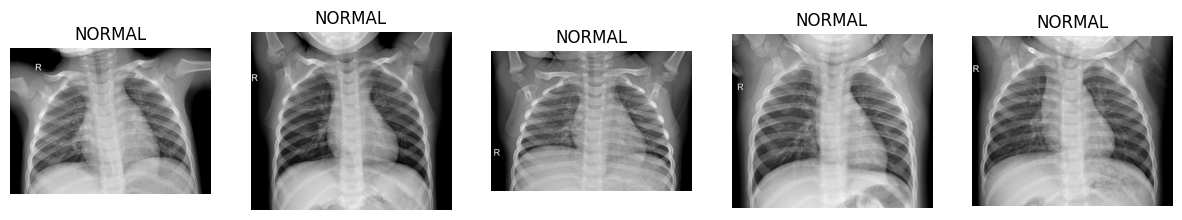

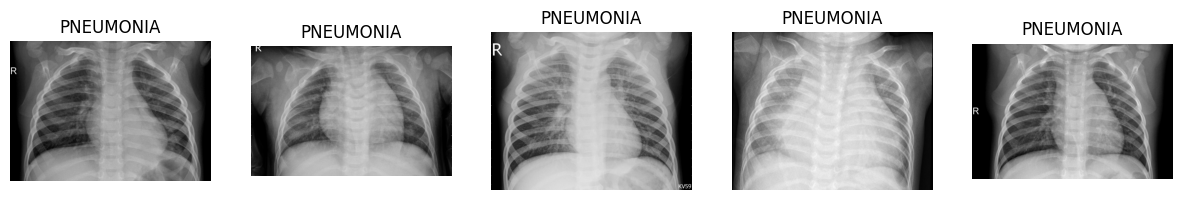

In [65]:
normal_images_path = '/content/chest_xray/train/NORMAL'
pneumonia_images_path = '/content/chest_xray/train/PNEUMONIA'

# Function to load & display images
def display_images(images_path, label, num_images=5):
    image_files = os.listdir(images_path)
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(images_path, image_file)
        img = plt.imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')  # Use cmap='gray' for grayscale images
        plt.title(label)
        plt.axis('off')
    plt.show()

# Display 5 random normal images
display_images(normal_images_path, 'NORMAL')

# Display 5 random pneumonia images
display_images(pneumonia_images_path, 'PNEUMONIA')

In [66]:
main_path='/content/chest_xray'

# Initialize a list to store the data
data = []
# Loop through the 'train', 'val', and 'test' folders
for subset in ['train', 'val', 'test']:
    # Loop through the 'PNEUMONIA' and 'NORMAL' folders
    for label in ['PNEUMONIA', 'NORMAL']:
        # Use glob to get all image files in one step
        image_paths = glob.glob(os.path.join(main_path, subset, label, '*'))
        # Add image paths and labels to the data list
        data.extend([{'images': path, 'labels': label}
                     for path in image_paths if path.lower().endswith(('.jpeg', '.jpg'))])

In [67]:
img_df = pd.DataFrame(data)
img_df = img_df.sample(len(img_df)).reset_index(drop=True)
img_df

,images,labels
0,/content/chest_xray/train/PNEUMONIA/person1592...,PNEUMONIA
1,/content/chest_xray/train/PNEUMONIA/person507_...,PNEUMONIA
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-04...,NORMAL
3,/content/chest_xray/train/PNEUMONIA/person487_...,PNEUMONIA
4,/content/chest_xray/train/PNEUMONIA/person1119...,PNEUMONIA
...,...,...
5851,/content/chest_xray/train/PNEUMONIA/person1896...,PNEUMONIA
5852,/content/chest_xray/train/NORMAL/NORMAL2-IM-05...,NORMAL
5853,/content/chest_xray/train/PNEUMONIA/person336_...,PNEUMONIA
5854,/content/chest_xray/train/PNEUMONIA/person890_...,PNEUMONIA


# Data Preprocessing

In [ ]:
# # Define image size and batch size
# IMG_SIZE = (224, 224)  # Adjust as needed
# BATCH_SIZE = 32

# # Create data generators for training and validation sets
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     '/content/chest_xray/train',
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary'  # or 'categorical' if you have more than two classes
# )

# test_generator = test_datagen.flow_from_directory(
#     '/content/chest_xray/test',
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary'  # or 'categorical'
# )

In [68]:
from sklearn.model_selection import train_test_split

# Split data menjadi train dan test set
train_df, test_df = train_test_split(img_df, test_size=0.2,
                                     stratify=img_df['labels'],
                                     random_state=42)

# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Generator untuk train set
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='images',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4684 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [69]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

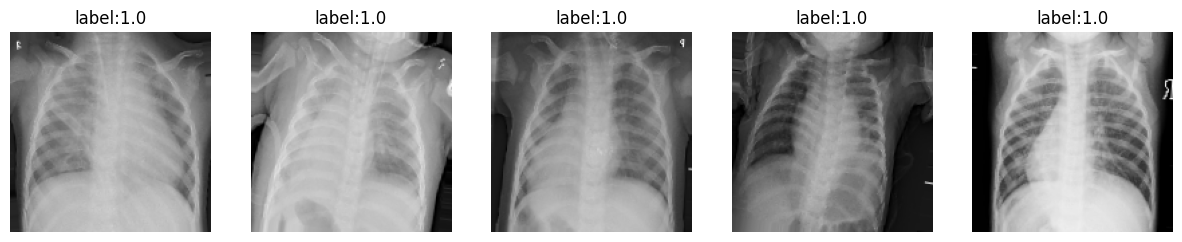

In [70]:
sample_images, sample_labels= next(train_generator)

plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(sample_images[i])
  plt.title('label:{}'.format(sample_labels[i]))
  plt.axis('off')
plt.show()

# Model Development

In [71]:
# Custom CNN
model = tf.keras.models.Sequential()

#model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(224, 224, 3)))
# input layer
model.add(tf.keras.layers.Input(shape=(224, 224, 3)))
# Convolutional Layer ke 1
model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
# Convolutional Layer ke 2
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
# Convolutional Layer ke 3
model.add(tf.keras.layers.Conv2D(64, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
# selain GlobalAveragePooling2D, kita bisa gunakan flatten
# model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [72]:
# Mengatur learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Mengompilasi model dengan optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,769 (253.00 KB)

 Trainable params: 64,769 (253.00 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_cnn= model.fit(train_generator, validation_data=test_generator,
            epochs=2)

Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7360 - loss: 0.5774 - val_accuracy: 0.7295 - val_loss: 0.5852
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7344 - loss: 0.5801 - val_accuracy: 0.7295 - val_loss: 0.5887


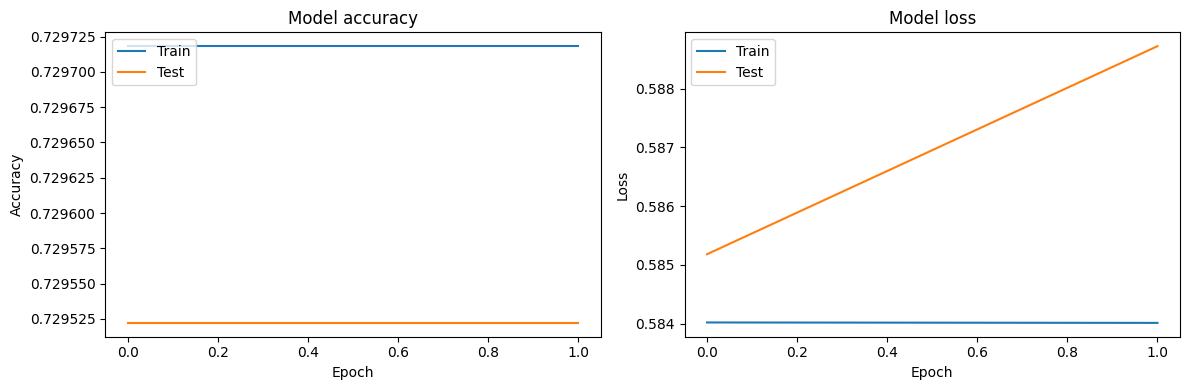

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
axes[0].plot(history_cnn.history['accuracy'])
axes[0].plot(history_cnn.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_cnn.history['loss'])
axes[1].plot(history_cnn.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step


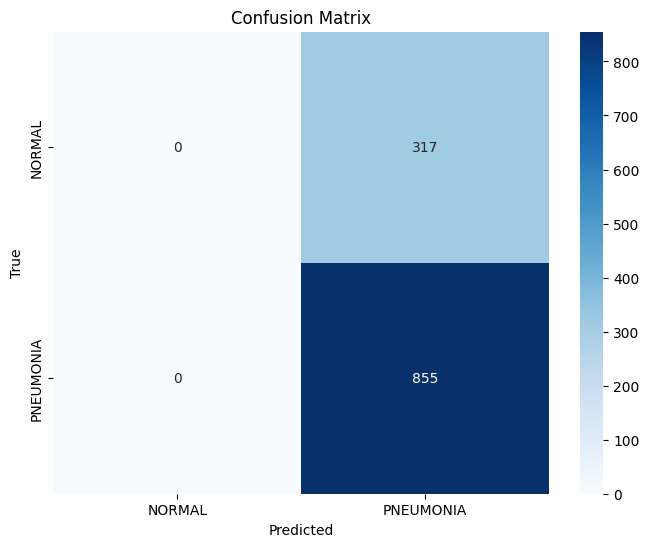

In [75]:
# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()


# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices,
            yticklabels=train_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [76]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_classes, target_names=list(train_generator.class_indices.keys())))

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       317
   PNEUMONIA       0.73      1.00      0.84       855

    accuracy                           0.73      1172
   macro avg       0.36      0.50      0.42      1172
weighted avg       0.53      0.73      0.62      1172



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Transfer Learning

Buatlah untuk transfer learning dengan VGG16 dan Xception

In [77]:
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D

## VGG16

In [78]:
#load pre-trained VGG16 model
base_model= VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
# lengkapi codenya di sini

## Xception

In [79]:
#load pre-trained ResNet50 model
base_model= Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [81]:
# Pastikan base model berjalan dalam mode inferensi
base_model.trainable = False

# Definisi input layer
# Change the input shape to match the Xception model's expected input shape
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

# Gunakan base model untuk ekstraksi fitur dalam mode inferensi
x = base_model(inputs, training=False)

# Konversi fitur ke vektor dengan Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Tambahkan layer Dense untuk klasifikasi biner dengan aktivasi sigmoid
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Buat model akhir
model = tf.keras.Model(inputs, outputs)

# Tampilkan ringkasan model
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [82]:
# Kompilasi model dengan loss dan optimizer yang sesuai
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
# Pastikan eksekusi eager aktif (seharusnya mencetak True)
print(tf.executing_eagerly())  # Harus mencetak True

True


In [86]:
# Generator untuk train set
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='labels',
    target_size=(224, 224),  # Change target_size to (224, 224)
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='images',
    y_col='labels',
    target_size=(224, 224),  # Change target_size to (224, 224)
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4684 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [88]:
# Melatih model menggunakan data training dan validasi
history_pre_trained = model.fit(train_generator, validation_data=test_generator, epochs=3)

Epoch 1/3


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

# Referensi

- [Tensorflow - Transfer Learning & Fine Tuning](https://www.tensorflow.org/guide/keras/transfer_learning)
- [Keras - Transfer Learning & Fine Tuning](https://keras.io/guides/transfer_learning/)
- [ Macam-macam model Transfer Learning di Keras](https://keras.io/api/applications/)